In [1]:
import random
import numpy as np
import torch
import os
from transformers import set_seed

def set_global_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    set_seed(seed)

set_global_seed(42)

In [4]:
# Required imports
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit

label_names = ['mistake_identification', 'mistake_location', 'providing_guidance', 'actionability']

# Load dataset
df = pd.read_csv("df_eda.csv")

df["conversation_history_cleaned"] = df["conversation_history"].apply(
    lambda context: context.replace(
        "Tutor: Hi, could you please provide a step-by-step solution for the question below? The question is:", "Tutor: "
    ).strip() if context.startswith("Tutor: Hi, could you please provide a step-by-step solution for the question below?") else context
)
df["last_student_utterance"] = df["conversation_history"].apply(lambda x: x.split("\n")[-1])

def stratified_group_split(df, label, test_size=0.2, seed=42):
    # Filter out conversations where all label values are missing
    valid_convs = df.groupby("conversation_id")[label].apply(lambda x: x.notna().any())
    valid_conv_ids = valid_convs[valid_convs].index

    df_valid = df[df["conversation_id"].isin(valid_conv_ids)]

    # Now group and compute mode for stratification
    grouped = df_valid.groupby("conversation_id")[label].agg(lambda x: x.dropna().mode().iloc[0] if not x.dropna().empty else None).dropna()
    grouped = grouped.reset_index().rename(columns={label: "label"})
    print(grouped["label"].value_counts())
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
    for train_idx, val_idx in sss.split(grouped["conversation_id"], grouped["label"]):
        train_ids = grouped.iloc[train_idx]["conversation_id"].tolist()
        val_ids = grouped.iloc[val_idx]["conversation_id"].tolist()

    train_df = df_valid[df_valid["conversation_id"].isin(train_ids)].reset_index(drop=True)
    val_df = df_valid[df_valid["conversation_id"].isin(val_ids)].reset_index(drop=True)

    return train_df, val_df

# Generate splits for each label
splits = {}
for label in label_names:
    train_df, val_df = stratified_group_split(df, label)
    splits[label] = {
        "train": train_df,
        "val": val_df
    }

for label in label_names:
  for split in ["train", "val"]:
    df_split = splits[label][split]
    df_split["classified_text"] = "Tutor: " + df_split["response"].str.strip()
    splits[label][split] = df_split

# Create distribution summary
distribution = []
for label in label_names:
    train_dist = splits[label]["train"][label].value_counts(normalize=True).sort_index()
    val_dist = splits[label]["val"][label].value_counts(normalize=True).sort_index()
    for cls in [0, 1, 2]:
        distribution.append({
            "Label": label,
            "Class": cls,
            "Train %": train_dist.get(cls, 0),
            "Val %": val_dist.get(cls, 0)
        })

dist_df = pd.DataFrame(distribution)
from IPython.display import display
display(dist_df)

label
2    282
0     12
1      6
Name: count, dtype: int64
label
2    216
0     69
1     15
Name: count, dtype: int64
label
2    204
1     50
0     46
Name: count, dtype: int64
label
2    185
0     92
1     23
Name: count, dtype: int64


,Label,Class,Train %,Val %
0,mistake_identification,0,0.149773,0.148073
1,mistake_identification,1,0.072113,0.062880
2,mistake_identification,2,0.778114,0.789047
3,mistake_location,0,0.292214,0.271084
4,mistake_location,1,0.088473,0.090361
5,mistake_location,2,0.619312,0.638554
6,providing_guidance,0,0.226263,0.237903
7,providing_guidance,1,0.203535,0.201613
8,providing_guidance,2,0.570202,0.560484
9,actionability,0,0.318526,0.335354


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base")
train_df=splits[label]["train"]
val_df=splits[label]["val"]
lengths = (train_df["conversation_history"] + " " + train_df["classified_text"]).apply(lambda x: len(tokenizer.tokenize(x)))
lengths.describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99])


,0
count,1981.000000
mean,303.857648
std,166.387970
min,36.000000
50%,340.000000
75%,415.000000
90%,474.000000
95%,511.000000
99%,577.200000
max,1401.000000


In [5]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which

In [6]:
from transformers import Trainer, TrainingArguments, AutoTokenizer
from transformers import AutoTokenizer, ModernBertForSequenceClassification, ModernBertConfig
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
import torch
from torch import nn
from datasets import Dataset
from typing import Dict

def compute_metrics_fn(label_name: str):
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=1)

        macro_f1 = f1_score(labels, preds, average="macro")
        macro_acc = accuracy_score(labels, preds)

        # Lenient metrics: map 0 -> 0, 1 or 2 -> 1
        to_binary = lambda x: 0 if x == 0 else 1
        binary_labels = list(map(to_binary, labels))
        binary_preds = list(map(to_binary, preds))

        lenient_f1 = f1_score(binary_labels, binary_preds, average="macro")
        lenient_acc = accuracy_score(binary_labels, binary_preds)

        # Optional: per-class metrics
        per_class_f1 = f1_score(labels, preds, average=None)

        metrics = {
            f"{label_name}_macro_f1": macro_f1,
            f"{label_name}_macro_acc": macro_acc,
            f"{label_name}_lenient_f1": lenient_f1,
            f"{label_name}_lenient_acc": lenient_acc,
        }
        for i, f1 in enumerate(per_class_f1):
            metrics[f"{label_name}_f1_class_{i}"] = f1

        return metrics

    return compute_metrics


def tokenize_dataset(train_df, val_df, label_name, model_id, max_length=512, use_context=True):
    tokenizer = AutoTokenizer.from_pretrained(model_id)

    def preprocess(example):
      if use_context:
            return tokenizer(
                example["context"],
                example["classified_text"],
                truncation=True,
                padding="max_length",
                max_length=max_length,
            )
      else:
            clean_response = [text.replace("Tutor: ", "").strip() for text in example["classified_text"]]
            return tokenizer(
                clean_response,
                truncation=True,
                padding="max_length",
                max_length=max_length,
            )

    train_ds = Dataset.from_pandas(train_df[["context", "classified_text", label_name]])
    val_ds = Dataset.from_pandas(val_df[["context", "classified_text", label_name]])

    train_ds = train_ds.rename_column(label_name, "labels")
    val_ds = val_ds.rename_column(label_name, "labels")

    train_ds = train_ds.map(preprocess, batched=True)
    val_ds = val_ds.map(preprocess, batched=True)

    train_ds.set_format("torch")
    val_ds.set_format("torch")

    return train_ds, val_ds, tokenizer


def train_modernbert_single_label(model_id: str, label_name: str, train_df, val_df, output_dir, num_train_epochs=5, use_context=True):
    train_ds, val_ds, tokenizer = tokenize_dataset(train_df, val_df, label_name, model_id, use_context)

    config = ModernBertConfig.from_pretrained(model_id)
    config.num_labels = 3

    model = ModernBertForSequenceClassification.from_pretrained(model_id, config=config)
    model.gradient_checkpointing_enable()

    training_args = TrainingArguments(
        output_dir=output_dir,
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=5e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=num_train_epochs,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model=f"{label_name}_macro_f1",
        report_to="none",
        logging_steps=50,
        logging_dir="./logs",
        save_total_limit=1,
        fp16=True,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics_fn(label_name)
    )

    trainer.train()
    return trainer, model, tokenizer

In [ ]:
torch.cuda.empty_cache()

In [ ]:
model_id = "answerdotai/ModernBERT-base"
label = "mistake_identification"
# 1. Full original conversation history
splits[label]["train"]["context"] = splits[label]["train"]["conversation_history"]
splits[label]["val"]["context"] = splits[label]["val"]["conversation_history"]
trainer1, model1, tokenizer1 = train_modernbert_single_label(model_id, label, splits[label]["train"], splits[label]["val"], "./out_full_context")


Map:   0%|          | 0/1983 [00:00<?, ? examples/s]

Map:   0%|          | 0/493 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-0603a3a1c2d1>:106: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Mistake Identification Macro F1,Mistake Identification Macro Acc,Mistake Identification Lenient F1,Mistake Identification Lenient Acc,Mistake Identification F1 Class 0,Mistake Identification F1 Class 1,Mistake Identification F1 Class 2
1,0.516000,0.559705,0.509072,0.845842,0.778565,0.900609,0.614173,0.000000,0.913043
2,0.468500,0.470706,0.547871,0.872211,0.838703,0.931034,0.716667,0.000000,0.926946
3,0.483900,0.471528,0.565133,0.880325,0.863551,0.937120,0.763359,0.000000,0.932039
4,0.314600,0.553269,0.607766,0.880325,0.873979,0.941176,0.781955,0.111111,0.930233
5,0.176000,0.736484,0.638103,0.860041,0.872354,0.941176,0.778626,0.218182,0.917500


In [ ]:
# 2. Cleaned conversation history
splits[label]["train"]["context"] = splits[label]["train"]["conversation_history_cleaned"]
splits[label]["val"]["context"] = splits[label]["val"]["conversation_history_cleaned"]
trainer2, model2, tokenizer2 = train_modernbert_single_label(model_id, label, splits[label]["train"], splits[label]["val"], "./out_cleaned_context")
del trainer2, model2, tokenizer2
torch.cuda.empty_cache()

# 3. Last student utterance only
splits[label]["train"]["context"] = splits[label]["train"]["last_student_utterance"]
splits[label]["val"]["context"] = splits[label]["val"]["last_student_utterance"]
trainer3, model3, tokenizer3 = train_modernbert_single_label(model_id, label, splits[label]["train"], splits[label]["val"], "./out_last_turn")
del trainer3, model3, tokenizer3
torch.cuda.empty_cache()

# 4. Response only (no context)
trainer4, model4, tokenizer4 = train_modernbert_single_label(model_id, label, splits[label]["train"], splits[label]["val"], "./out_response_only", use_context=False)
del trainer4, model4, tokenizer4
torch.cuda.empty_cache()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/1983 [00:00<?, ? examples/s]

Map:   0%|          | 0/493 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-4-6eaf5908e219>:106: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
W0413 21:24:45.540000 14148 torch/_inductor/utils.py:1137] [1/0] Not enough SMs to use max_autotune_gemm mode


Epoch,Training Loss,Validation Loss,Mistake Identification Macro F1,Mistake Identification Macro Acc,Mistake Identification Lenient F1,Mistake Identification Lenient Acc,Mistake Identification F1 Class 0,Mistake Identification F1 Class 1,Mistake Identification F1 Class 2
1,0.689700,0.640382,0.294029,0.789047,0.460022,0.851927,0.000000,0.000000,0.882086
2,0.569600,0.510101,0.505930,0.851927,0.778023,0.914807,0.603774,0.000000,0.914016
3,0.544200,0.515541,0.554800,0.878296,0.846734,0.933063,0.731707,0.000000,0.932692
4,0.441000,0.462878,0.585996,0.868154,0.837941,0.922921,0.720588,0.111111,0.926290
5,0.318200,0.550478,0.626843,0.878296,0.849371,0.931034,0.738462,0.210526,0.931540


Map:   0%|          | 0/1983 [00:00<?, ? examples/s]

Map:   0%|          | 0/493 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-4-6eaf5908e219>:106: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Mistake Identification Macro F1,Mistake Identification Macro Acc,Mistake Identification Lenient F1,Mistake Identification Lenient Acc,Mistake Identification F1 Class 0,Mistake Identification F1 Class 1,Mistake Identification F1 Class 2
1,0.434400,0.474782,0.580252,0.864097,0.831650,0.922921,0.707692,0.111111,0.921951
2,0.408900,0.456375,0.639097,0.886410,0.870984,0.945233,0.773109,0.210526,0.933655
3,0.277300,0.591350,0.634301,0.878296,0.858477,0.931034,0.757143,0.216216,0.929543
4,0.121600,0.965318,0.656579,0.886410,0.882670,0.945233,0.796992,0.238095,0.934649
5,0.003900,1.052224,0.660231,0.880325,0.884813,0.947262,0.800000,0.250000,0.930693


Map:   0%|          | 0/1983 [00:00<?, ? examples/s]

Map:   0%|          | 0/493 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-4-6eaf5908e219>:106: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Mistake Identification Macro F1,Mistake Identification Macro Acc,Mistake Identification Lenient F1,Mistake Identification Lenient Acc,Mistake Identification F1 Class 0,Mistake Identification F1 Class 1,Mistake Identification F1 Class 2
1,0.455100,0.442971,0.626028,0.876268,0.849371,0.931034,0.738462,0.210526,0.929095
2,0.433700,0.526590,0.590377,0.866126,0.795573,0.920892,0.635514,0.210526,0.925089
3,0.273800,0.651415,0.654189,0.894523,0.880588,0.943205,0.794118,0.228571,0.939877
4,0.095900,1.041496,0.653062,0.878296,0.856764,0.931034,0.753623,0.272727,0.932836
5,0.000200,1.147678,0.635127,0.882353,0.861818,0.935091,0.761194,0.210526,0.933661


In [7]:
from collections import Counter

label_counts = Counter(train_df[label])
total = sum(label_counts.values())
weights = [total / label_counts.get(cls, 1) for cls in range(3)]
weights = torch.tensor(weights, dtype=torch.float)

In [12]:
!pip install optuna

# Pt Optuna:

In [9]:
from transformers import Trainer

class CustomTrainer(Trainer):
    def __init__(self, loss_type="cross_entropy", **kwargs):
        super().__init__(**kwargs)
        self.loss_type = loss_type

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        if self.loss_type == "cross_entropy":
            loss_fct = torch.nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)
        elif self.loss_type == "weighted_ce":
            class_weights = weights.to(logits.device)
            loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
            loss = loss_fct(logits, labels)
        elif self.loss_type == "focal":
            ce_loss = torch.nn.functional.cross_entropy(logits, labels, reduction='none')
            pt = torch.exp(-ce_loss)
            loss = ((1 - pt) ** 2 * ce_loss).mean()
        else:
            raise ValueError("Unsupported loss type")

        return (loss, outputs) if return_outputs else loss


In [16]:
def train_modernbert_single_label(model_id: str, label_name: str, train_df, val_df, output_dir,
                                   learning_rate=5e-5, weight_decay=0.01, batch_size=8,
                                   num_train_epochs=5, warmup_steps=0, loss_type="cross_entropy",
                                   use_context=True, hidden_dropout_prob=None):
    train_ds, val_ds, tokenizer = tokenize_dataset(train_df, val_df, label_name, model_id, use_context=use_context)

    config = ModernBertConfig.from_pretrained(model_id)
    config.num_labels = 3
    if hidden_dropout_prob is not None:
        config.hidden_dropout_prob = hidden_dropout_prob

    model = ModernBertForSequenceClassification.from_pretrained(model_id, config=config)
    model.train()

    def custom_compute_loss(model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        if loss_type == "cross_entropy":
            loss_fct = torch.nn.CrossEntropyLoss()
        elif loss_type == "weighted_ce":
            class_weights = weights.to(logits.device)
            loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
        elif loss_type == "focal":
            ce_loss = torch.nn.functional.cross_entropy(logits, labels, reduction='none')
            pt = torch.exp(-ce_loss)
            loss = ((1 - pt) ** 2 * ce_loss).mean()
            return (loss, outputs) if return_outputs else loss
        else:
            raise ValueError("Unsupported loss type")

        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

    training_args = TrainingArguments(
        output_dir=output_dir,
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_train_epochs,
        weight_decay=weight_decay,
        warmup_steps=warmup_steps,
        load_best_model_at_end=True,
        metric_for_best_model=f"{label_name}_macro_f1",
        report_to="none",
        logging_steps=50,
        logging_dir="./logs",
        save_total_limit=1,
        seed=42,
    )

    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics_fn(label_name),
        loss_type=loss_type
    )

    trainer.train()
    eval_metrics = trainer.evaluate()
    metric_key = f"eval_{training_args.metric_for_best_model}"
    metric_value = eval_metrics.get(metric_key, 0.0)
    return trainer, model, tokenizer, metric_value

In [ ]:
import optuna
from optuna.pruners import MedianPruner

def objective(trial):
    model_id = "answerdotai/ModernBERT-base"
    label_name = "mistake_identification"
    use_context = True
    output_dir = f"./optuna_trial_{trial.number}"

    # Hyperparameter search space
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 5e-4, log=True)
    weight_decay = trial.suggest_float("weight_decay", 0.0, 0.3)
    batch_size = trial.suggest_categorical("batch_size", [4, 8, 16])
    # warmup_steps = trial.suggest_int("warmup_steps", 0, 200)
    # num_train_epochs = trial.suggest_int("num_train_epochs", 3, 6)
    num_train_epochs = 4
    warmup_steps = 0
    loss_type = trial.suggest_categorical("loss_type", ["cross_entropy", "weighted_ce", "focal"])

    # Optionally add architecture tuning later:
    # hidden_dropout_prob = trial.suggest_float("hidden_dropout_prob", 0.0, 0.3)
    hidden_dropout_prob = None

    # Use fixed split
    splits[label_name]["train"]["context"] = splits[label_name]["train"]["conversation_history"]
    splits[label_name]["val"]["context"] = splits[label_name]["val"]["conversation_history"]
    train_df = splits[label_name]["train"]
    val_df = splits[label_name]["val"]

    _, _, _, metric = train_modernbert_single_label(
        model_id=model_id,
        label_name=label_name,
        train_df=train_df,
        val_df=val_df,
        output_dir=output_dir,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        batch_size=batch_size,
        num_train_epochs=num_train_epochs,
        warmup_steps=warmup_steps,
        loss_type=loss_type,
        use_context=use_context,
        hidden_dropout_prob=hidden_dropout_prob,
    )
    trial.report(metric, step=1)

    if trial.should_prune():
      raise optuna.TrialPruned()

    return metric

# Launch the study with SQLite storage
study = optuna.create_study(
    direction="maximize",
    pruner=MedianPruner(n_warmup_steps=1),
    study_name="modernbert_optuna_mistakeid",
    storage="sqlite:///optuna_modernbert.db",
    load_if_exists=True,
)
study.optimize(objective, n_trials=15)

# Best trial
print("Best trial:")
print(study.best_trial)
print("Best hyperparameters:")
print(study.best_trial.params)


[I 2025-04-14 23:57:33,899] Using an existing study with name 'modernbert_optuna_mistakeid' instead of creating a new one.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

Map:   0%|          | 0/1983 [00:00<?, ? examples/s]

Map:   0%|          | 0/493 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-9-0dc5d99e4e93>:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(**kwargs)
W0414 23:57:57.136000 192 torch/_inductor/utils.py:1137] [1/0] Not enough SMs to use max_autotune_gemm mode


Epoch,Training Loss,Validation Loss,Mistake Identification Macro F1,Mistake Identification Macro Acc,Mistake Identification Lenient F1,Mistake Identification Lenient Acc,Mistake Identification F1 Class 0,Mistake Identification F1 Class 1,Mistake Identification F1 Class 2
1,0.651700,0.639993,0.294029,0.789047,0.460022,0.851927,0.000000,0.000000,0.882086
2,0.612800,0.644970,0.299611,0.776876,0.468699,0.839757,0.024691,0.000000,0.874142
3,0.658500,0.625315,0.293182,0.784990,0.458836,0.847870,0.000000,0.000000,0.879545
4,0.610900,0.623083,0.292757,0.782961,0.458242,0.845842,0.000000,0.000000,0.878271


[I 2025-04-15 00:18:03,238] Trial 1 finished with value: 0.2996110781516324 and parameters: {'learning_rate': 1.5633797795564837e-06, 'weight_decay': 0.17288233454879579, 'batch_size': 16, 'loss_type': 'cross_entropy'}. Best is trial 1 with value: 0.2996110781516324.


Map:   0%|          | 0/1983 [00:00<?, ? examples/s]

Map:   0%|          | 0/493 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-9-0dc5d99e4e93>:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(**kwargs)


Epoch,Training Loss,Validation Loss,Mistake Identification Macro F1,Mistake Identification Macro Acc,Mistake Identification Lenient F1,Mistake Identification Lenient Acc,Mistake Identification F1 Class 0,Mistake Identification F1 Class 1,Mistake Identification F1 Class 2
1,0.391400,0.345780,0.294029,0.789047,0.460022,0.851927,0.000000,0.000000,0.882086
2,0.404800,0.268697,0.491240,0.831643,0.754319,0.890467,0.571429,0.000000,0.902292
3,0.279800,0.230708,0.529341,0.849899,0.811565,0.908722,0.676259,0.000000,0.911765
4,0.296500,0.228844,0.547760,0.868154,0.840980,0.931034,0.721311,0.000000,0.921969


[I 2025-04-15 00:40:18,595] Trial 2 finished with value: 0.5477600876416141 and parameters: {'learning_rate': 0.000246782443470204, 'weight_decay': 0.24417729126409166, 'batch_size': 4, 'loss_type': 'focal'}. Best is trial 2 with value: 0.5477600876416141.


Map:   0%|          | 0/1983 [00:00<?, ? examples/s]

Map:   0%|          | 0/493 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-9-0dc5d99e4e93>:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(**kwargs)


Epoch,Training Loss,Validation Loss,Mistake Identification Macro F1,Mistake Identification Macro Acc,Mistake Identification Lenient F1,Mistake Identification Lenient Acc,Mistake Identification F1 Class 0,Mistake Identification F1 Class 1,Mistake Identification F1 Class 2
1,0.883000,0.872433,0.293606,0.787018,0.460022,0.851927,0.000000,0.000000,0.880817
2,0.806100,0.817739,0.442066,0.793103,0.604295,0.851927,0.291262,0.150000,0.884935
3,0.716900,0.785345,0.519692,0.809331,0.727059,0.870183,0.529412,0.136364,0.893300
4,0.581400,0.798741,0.523231,0.807302,0.741448,0.876268,0.554745,0.122449,0.892500


[I 2025-04-15 01:00:36,696] Trial 3 finished with value: 0.5232311683797607 and parameters: {'learning_rate': 6.861714301758497e-06, 'weight_decay': 0.06648447565214201, 'batch_size': 16, 'loss_type': 'weighted_ce'}. Best is trial 2 with value: 0.5477600876416141.


Map:   0%|          | 0/1983 [00:00<?, ? examples/s]

Map:   0%|          | 0/493 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-9-0dc5d99e4e93>:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(**kwargs)


Epoch,Training Loss,Validation Loss,Mistake Identification Macro F1,Mistake Identification Macro Acc,Mistake Identification Lenient F1,Mistake Identification Lenient Acc,Mistake Identification F1 Class 0,Mistake Identification F1 Class 1,Mistake Identification F1 Class 2
1,0.293400,0.270722,0.294029,0.789047,0.460022,0.851927,0.000000,0.000000,0.882086
2,0.323900,0.260921,0.303371,0.791075,0.474040,0.853955,0.027027,0.000000,0.883087
3,0.232200,0.272308,0.312576,0.793103,0.486755,0.853955,0.052632,0.000000,0.885097
4,0.284200,0.275010,0.345077,0.799189,0.534454,0.858012,0.146341,0.000000,0.888889


[I 2025-04-15 01:23:18,457] Trial 4 finished with value: 0.3450767841011743 and parameters: {'learning_rate': 1.1933670676039588e-06, 'weight_decay': 0.19212052978034547, 'batch_size': 4, 'loss_type': 'focal'}. Best is trial 2 with value: 0.5477600876416141.


Map:   0%|          | 0/1983 [00:00<?, ? examples/s]

Map:   0%|          | 0/493 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-9-0dc5d99e4e93>:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(**kwargs)


Epoch,Training Loss,Validation Loss,Mistake Identification Macro F1,Mistake Identification Macro Acc,Mistake Identification Lenient F1,Mistake Identification Lenient Acc,Mistake Identification F1 Class 0,Mistake Identification F1 Class 1,Mistake Identification F1 Class 2
1,0.273000,0.317182,0.294029,0.789047,0.460022,0.851927,0.000000,0.000000,0.882086
2,0.226900,0.208199,0.568212,0.866126,0.808618,0.922921,0.660714,0.121212,0.922711
3,0.201900,0.184510,0.581911,0.870183,0.833908,0.931034,0.706897,0.114286,0.924551
4,0.095300,0.218191,0.642798,0.876268,0.855000,0.931034,0.750000,0.250000,0.928395


[I 2025-04-15 01:43:59,704] Trial 5 finished with value: 0.6427983539094649 and parameters: {'learning_rate': 4.832210191782853e-05, 'weight_decay': 0.24499721270646885, 'batch_size': 16, 'loss_type': 'focal'}. Best is trial 5 with value: 0.6427983539094649.


Map:   0%|          | 0/1983 [00:00<?, ? examples/s]

Map:   0%|          | 0/493 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-9-0dc5d99e4e93>:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(**kwargs)


Epoch,Training Loss,Validation Loss,Mistake Identification Macro F1,Mistake Identification Macro Acc,Mistake Identification Lenient F1,Mistake Identification Lenient Acc,Mistake Identification F1 Class 0,Mistake Identification F1 Class 1,Mistake Identification F1 Class 2
1,0.303700,0.259500,0.294029,0.789047,0.460022,0.851927,0.000000,0.000000,0.882086
2,0.315000,0.251596,0.321342,0.795132,0.499907,0.855984,0.077922,0.000000,0.886105
3,0.231100,0.272775,0.405260,0.813387,0.623700,0.870183,0.319149,0.000000,0.896632
4,0.270000,0.288730,0.408334,0.811359,0.628391,0.868154,0.329897,0.000000,0.895105


[I 2025-04-15 02:06:59,997] Trial 6 pruned. 


Map:   0%|          | 0/1983 [00:00<?, ? examples/s]

Map:   0%|          | 0/493 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-9-0dc5d99e4e93>:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(**kwargs)


Epoch,Training Loss,Validation Loss,Mistake Identification Macro F1,Mistake Identification Macro Acc,Mistake Identification Lenient F1,Mistake Identification Lenient Acc,Mistake Identification F1 Class 0,Mistake Identification F1 Class 1,Mistake Identification F1 Class 2
1,0.677800,0.638447,0.294029,0.789047,0.460022,0.851927,0.000000,0.000000,0.882086
2,0.616000,0.513182,0.512664,0.849899,0.788359,0.912779,0.626087,0.000000,0.911905
3,0.574100,0.479815,0.545232,0.866126,0.835002,0.924949,0.713178,0.000000,0.922518
4,0.384600,0.568443,0.567181,0.847870,0.809198,0.902637,0.675676,0.114286,0.911582


[I 2025-04-15 02:28:08,462] Trial 7 finished with value: 0.5671809863590686 and parameters: {'learning_rate': 9.864966444342608e-05, 'weight_decay': 0.16143535179279933, 'batch_size': 8, 'loss_type': 'cross_entropy'}. Best is trial 5 with value: 0.6427983539094649.


Map:   0%|          | 0/1983 [00:00<?, ? examples/s]

Map:   0%|          | 0/493 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-9-0dc5d99e4e93>:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(**kwargs)


Epoch,Training Loss,Validation Loss,Mistake Identification Macro F1,Mistake Identification Macro Acc,Mistake Identification Lenient F1,Mistake Identification Lenient Acc,Mistake Identification F1 Class 0,Mistake Identification F1 Class 1,Mistake Identification F1 Class 2
1,0.264500,0.261625,0.293606,0.787018,0.460022,0.851927,0.000000,0.000000,0.880817
2,0.229500,0.239372,0.390725,0.813387,0.602892,0.872211,0.275862,0.000000,0.896313
3,0.209300,0.242254,0.487305,0.827586,0.717963,0.886410,0.500000,0.060606,0.901308
4,0.184000,0.238265,0.482226,0.831643,0.740080,0.890467,0.542373,0.000000,0.904306


[I 2025-04-15 02:49:30,130] Trial 8 pruned. 


Map:   0%|          | 0/1983 [00:00<?, ? examples/s]

Map:   0%|          | 0/493 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-9-0dc5d99e4e93>:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(**kwargs)


Epoch,Training Loss,Validation Loss,Mistake Identification Macro F1,Mistake Identification Macro Acc,Mistake Identification Lenient F1,Mistake Identification Lenient Acc,Mistake Identification F1 Class 0,Mistake Identification F1 Class 1,Mistake Identification F1 Class 2
1,0.279000,0.272377,0.294029,0.789047,0.460022,0.851927,0.000000,0.000000,0.882086
2,0.257800,0.265963,0.301748,0.784990,0.471733,0.847870,0.025974,0.000000,0.879271
3,0.280600,0.263641,0.294029,0.789047,0.460022,0.851927,0.000000,0.000000,0.882086
4,0.258400,0.263100,0.294029,0.789047,0.460022,0.851927,0.000000,0.000000,0.882086


[I 2025-04-15 03:09:59,249] Trial 9 pruned. 


Map:   0%|          | 0/1983 [00:00<?, ? examples/s]

Map:   0%|          | 0/493 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-9-0dc5d99e4e93>:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(**kwargs)


Epoch,Training Loss,Validation Loss,Mistake Identification Macro F1,Mistake Identification Macro Acc,Mistake Identification Lenient F1,Mistake Identification Lenient Acc,Mistake Identification F1 Class 0,Mistake Identification F1 Class 1,Mistake Identification F1 Class 2
1,0.907300,0.894147,0.294029,0.789047,0.460022,0.851927,0.000000,0.000000,0.882086
2,0.865500,0.885856,0.294029,0.789047,0.460022,0.851927,0.000000,0.000000,0.882086
3,0.912700,0.874617,0.294029,0.789047,0.460022,0.851927,0.000000,0.000000,0.882086
4,0.853700,0.872750,0.294029,0.789047,0.460022,0.851927,0.000000,0.000000,0.882086


[I 2025-04-15 03:30:17,395] Trial 10 pruned. 


Map:   0%|          | 0/1983 [00:00<?, ? examples/s]

Map:   0%|          | 0/493 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-9-0dc5d99e4e93>:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(**kwargs)


Epoch,Training Loss,Validation Loss,Mistake Identification Macro F1,Mistake Identification Macro Acc,Mistake Identification Lenient F1,Mistake Identification Lenient Acc,Mistake Identification F1 Class 0,Mistake Identification F1 Class 1,Mistake Identification F1 Class 2
1,0.641000,0.619114,0.294029,0.789047,0.460022,0.851927,0.000000,0.000000,0.882086
2,0.488500,0.459456,0.554746,0.858012,0.819535,0.916836,0.687023,0.058824,0.918392
3,0.392500,0.431486,0.600458,0.878296,0.861759,0.937120,0.759690,0.111111,0.930572
4,0.243300,0.485947,0.643289,0.876268,0.865190,0.935091,0.768116,0.232558,0.929193


[I 2025-04-15 03:50:44,337] Trial 11 finished with value: 0.64328887604924 and parameters: {'learning_rate': 3.5537063478236856e-05, 'weight_decay': 0.004482892590733034, 'batch_size': 16, 'loss_type': 'cross_entropy'}. Best is trial 11 with value: 0.64328887604924.


Map:   0%|          | 0/1983 [00:00<?, ? examples/s]

Map:   0%|          | 0/493 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-9-0dc5d99e4e93>:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(**kwargs)


Epoch,Training Loss,Validation Loss,Mistake Identification Macro F1,Mistake Identification Macro Acc,Mistake Identification Lenient F1,Mistake Identification Lenient Acc,Mistake Identification F1 Class 0,Mistake Identification F1 Class 1,Mistake Identification F1 Class 2
1,0.626900,0.606276,0.293606,0.787018,0.460022,0.851927,0.000000,0.000000,0.880817


Train loss graph

<Figure size 640x480 with 0 Axes>

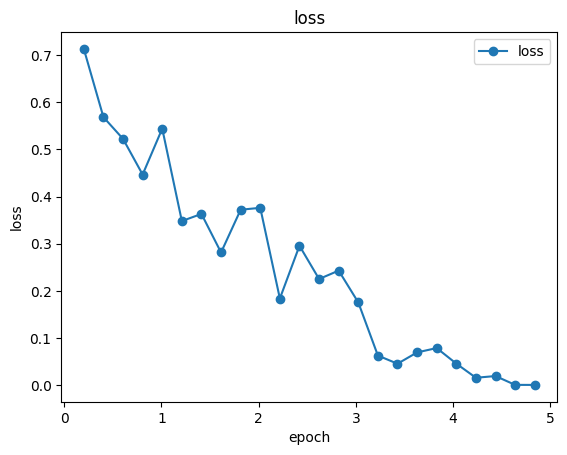

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Load logs
with open(f"./model_{label}_cleaned_conv_output/checkpoint-1240/trainer_state.json") as f:
    state = json.load(f)

logs = pd.DataFrame(state["log_history"])

# Plot metrics
for metric in ["loss", f"{label}_macro_f1", f"{label}_macro_acc"]:
    if metric in logs.columns:
        plt.figure()
        logs.dropna(subset=[metric]).plot(x="epoch", y=metric, marker="o", title=metric)
        plt.ylabel(metric)
        plt.show()


%load_ext tensorboard
%tensorboard --logdir ./logs


Confusion matrix

Map:   0%|          | 0/495 [00:00<?, ? examples/s]

Map:   0%|          | 0/495 [00:00<?, ? examples/s]

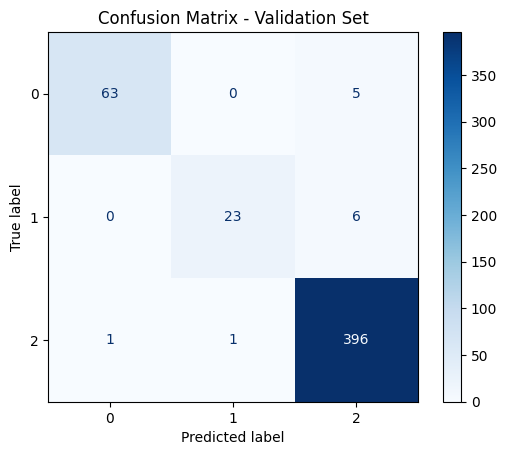

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Reuse the tokenize_dataset function from your training code
_, val_ds, _ = tokenize_dataset(val_df, val_df, label_name="mistake_identification", model_id="answerdotai/ModernBERT-base")

# Get predictions on validation set
preds = trainer.predict(val_ds)
y_true = preds.label_ids
y_pred = preds.predictions.argmax(axis=1)

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Validation Set")
plt.show()


Save & reload model later

In [ ]:
# Save model, tokenizer, config
model.save_pretrained("models/modernbert_mistake_identification_clean_base")
tokenizer.save_pretrained("models/modernbert_mistake_identification_clean_base")


('models/modernbert_mistake_identification_clean_base/tokenizer_config.json',
 'models/modernbert_mistake_identification_clean_base/special_tokens_map.json',
 'models/modernbert_mistake_identification_clean_base/tokenizer.json')

In [ ]:
from models.modernbert.modeling_modernbert import ModernBertForSequenceClassification
from transformers import AutoTokenizer

model = ModernBertForSequenceClassification.from_pretrained("models/modernbert_mistake_identification_clean_base")
tokenizer = AutoTokenizer.from_pretrained("models/modernbert_mistake_identification_clean_base")
